In [687]:
# overhead

import logging
import math
import random
import numpy as np
import time
import torch as t
import torch.nn as nn
from torch import optim
from torch.nn import utils
import matplotlib.pyplot as plt

logger = logging.getLogger(__name__)

In [688]:
# environment parameters

FRAME_TIME = 0.1  # time interval
GRAVITY_ACCEL = 0.2  # gravity constant
BOOST_ACCEL = 0.55  # thrust constant
DRAG_COEFF = 0.25 # Drag coefficient
S = 0.1 # Surface Area of rocket
RHO = 0.1225 # Air Density at sea level
FPA_GAIN = 0.55

In [689]:
# define system dynamics
# Notes: 
# 0. You only need to modify the "forward" function
# 1. All variables in "forward" need to be PyTorch tensors.
# 2. All math operations in "forward" has to be differentiable, e.g., default PyTorch functions.
# 3. Do not use inplace operations, e.g., x += 1. Please see the following section for an example that does not work.

class Dynamics(nn.Module):
    def __init__(self):
        super(Dynamics, self).__init__()
    @staticmethod
    def forward(state, action):
        """
        action[0]: thrust control
        action[1]: fpa control
        state[0] = x
        state[1] = x_dot
        state[2] = fpa
        state[3] = fpa_dot
        ###
        fpa_dot(t+1) = fpa_dot(t) + (gsin(fpa) - action[1])*dt
        """
        delta_x_dot = (t.tensor([0.,(GRAVITY_ACCEL*t.cos(state.detach()[2])) - (0.5*RHO*(state.detach()[1]**2)*S*DRAG_COEFF) - BOOST_ACCEL*action[0], 0., 0.])*FRAME_TIME) - (t.tensor([0., 1., 0., 0.])*BOOST_ACCEL*action[0]*FRAME_TIME)
        delta_fpa_dot = (t.tensor([0., 0., 0., (GRAVITY_ACCEL*t.sin(state.detach()[2]))])*FRAME_TIME) - (t.tensor([0., 0., 0., 1.])*FPA_GAIN*action[1]*FRAME_TIME)
        step_mat = t.tensor([[1., FRAME_TIME, 0., 0.],
                             [0., 1., 0., 0.,],
                             [0., 0., 1., FRAME_TIME],
                             [0., 0., 0., 1.]
                            ])
        state = t.matmul(step_mat, state)
        state = state + delta_x_dot + delta_fpa_dot


        # delta_state_gravity = t.tensor([0., GRAVITY_ACCEL * FRAME_TIME]) 
        # delta_state_drag = t.tensor([0., -0.5*RHO*S*DRAG_COEFF*FRAME_TIME*(state.detach().clone()[1]**2)])
        # delta_state = BOOST_ACCEL * FRAME_TIME * t.tensor([0., -1.]) * action

        # step_mat = t.tensor([[1., FRAME_TIME],
        #                     [0., 1.]])
        # state = t.matmul(step_mat, state)
        # state = state + delta_state + delta_state_gravity + delta_state_drag
        
        return state

In [690]:
# a deterministic controller
# Note:
# 0. You only need to change the network architecture in "__init__"
# 1. nn.Sigmoid outputs values from 0 to 1, nn.Tanh from -1 to 1
# 2. You have all the freedom to make the network wider (by increasing "dim_hidden") or deeper (by adding more lines to nn.Sequential)
# 3. Always start with something simple

class Controller(nn.Module):

    def __init__(self, dim_input, dim_hidden, dim_output):
        """
        dim_input: # of system states
        dim_output: # of actions
        dim_hidden: up to you
        """
        super(Controller, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(dim_input, dim_hidden),
            nn.Tanh(),
            nn.Linear(dim_hidden, 48),
            nn.Tanh(),
            nn.Linear(48, 64),
            nn.Linear(64, dim_output),
            # You can add more layers here
            nn.Sigmoid()
        )

    def forward(self, state):
        action = self.network(state)
        return action

In [691]:
# the simulator that rolls out x(1), x(2), ..., x(T)
# Note:
# 0. Need to change "initialize_state" to optimize the controller over a distribution of initial states
# 1. self.action_trajectory and self.state_trajectory stores the action and state trajectories along time

class Simulation(nn.Module):

    def __init__(self, controller, dynamics, T):
        super(Simulation, self).__init__()
        self.state = self.initialize_state()
        self.controller = controller
        self.dynamics = dynamics
        self.T = T
        self.action_trajectory = []
        self.state_trajectory = []

    def forward(self, state):
        self.action_trajectory = []
        self.state_trajectory = []
        for _ in range(T):
            action = self.controller.forward(state)
            state = self.dynamics.forward(state, action)
            self.action_trajectory.append(action)
            self.state_trajectory.append(state)
        return self.error(state)

    @staticmethod
    def initialize_state():
        state = [1., 0., 0.25, 0.] # TODO: need batch of initial states
        return t.tensor(state, requires_grad=False).float()

    def error(self, state):
        return state[0]**2 + state[1]**2 + state[2]**2 + state[3]**2
        # return state[0]**2 + state[1]**2

In [692]:
# set up the optimizer
# Note:
# 0. LBFGS is a good choice if you don't have a large batch size (i.e., a lot of initial states to consider simultaneously)
# 1. You can also try SGD and other momentum-based methods implemented in PyTorch
# 2. You will need to customize "visualize"
# 3. loss.backward is where the gradient is calculated (d_loss/d_variables)
# 4. self.optimizer.step(closure) is where gradient descent is done

class Optimize:
    def __init__(self, simulation):
        self.simulation = simulation
        self.parameters = simulation.controller.parameters()
        self.optimizer = optim.LBFGS(self.parameters, lr=0.001)
        # self.scheduler = optim.lr_scheduler.StepLR(optimizer = self.optimizer, step_size = 25,gamma = 0.5)
        
        self.losses = []
    def step(self):
        def closure():
            loss = self.simulation(self.simulation.state)
            self.optimizer.zero_grad()
            loss.backward()
            self.parameters
            return loss
        self.optimizer.step(closure)
        # self.scheduler.step()
        return closure()
    
    def train(self, epochs):
        best_loss = 1e10
        self.losses = []
        for epoch in range(epochs):
            loss = self.step()
            self.losses.append(loss.data)
            if loss < best_loss:
                best_loss = loss
                best_state_trajectory = self.simulation.state_trajectory
                best_action_trajectory = self.simulation.action_trajectory
                print("Best loss:", best_loss.data, "Saving trajectory data...")
                
            if epoch%1 == 0: 
                print('[%d] loss: %.3f' % (epoch + 1, loss))
                if epoch == epochs -1 or best_loss == 0.:
                    self.visualize(best_state_trajectory, best_action_trajectory)
                    print("Final state vector for the best trajectory: ", best_state_trajectory[99])
                    break

    def visualize(self, state_trajectory = None, action_trajectory = None):
        data = np.array([state_trajectory[i].detach().numpy() for i in range(self.simulation.T)])
        action_data = np.array([action_trajectory[i].detach().numpy() for i in range(self.simulation.T)])
        x = data[:, 0]
        x_dot = data[:, 1]
        fpa = data[:, 2]
        fpa_dot = data[:, 3]
        plt.plot(x)
        plt.xlabel('Time_Steps')
        plt.ylabel('Distance')
        plt.show()
        plt.plot(x_dot)
        plt.xlabel('Time_step')
        plt.ylabel('Speed')
        plt.show()
        plt.plot(fpa)
        plt.xlabel('Time_step')
        plt.ylabel('Flight Path Angle')
        plt.show()
        plt.plot(fpa_dot)
        plt.xlabel('Time_step')
        plt.ylabel('Angular speed')
        plt.show()
        plt.plot(self.losses)
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.show()


Best loss: tensor(541.5110) Saving trajectory data...
[1] loss: 541.511
Best loss: tensor(446.3453) Saving trajectory data...
[2] loss: 446.345
Best loss: tensor(367.9007) Saving trajectory data...
[3] loss: 367.901
Best loss: tensor(311.5571) Saving trajectory data...
[4] loss: 311.557
Best loss: tensor(259.9711) Saving trajectory data...
[5] loss: 259.971
Best loss: tensor(214.0927) Saving trajectory data...
[6] loss: 214.093
Best loss: tensor(176.3095) Saving trajectory data...
[7] loss: 176.309
Best loss: tensor(144.6444) Saving trajectory data...
[8] loss: 144.644
Best loss: tensor(119.3076) Saving trajectory data...
[9] loss: 119.308
Best loss: tensor(97.5466) Saving trajectory data...
[10] loss: 97.547
Best loss: tensor(79.9301) Saving trajectory data...
[11] loss: 79.930
Best loss: tensor(64.5086) Saving trajectory data...
[12] loss: 64.509
Best loss: tensor(53.3634) Saving trajectory data...
[13] loss: 53.363
Best loss: tensor(44.9565) Saving trajectory data...
[14] loss: 44.9

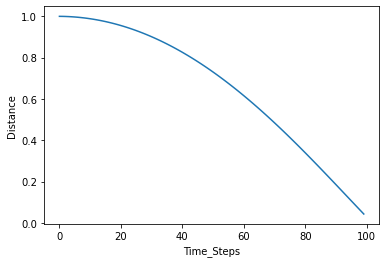

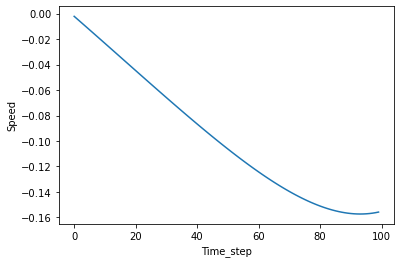

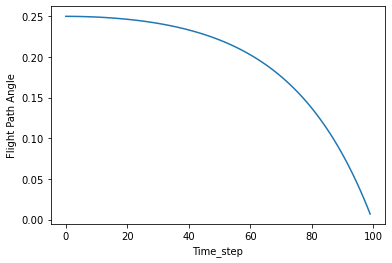

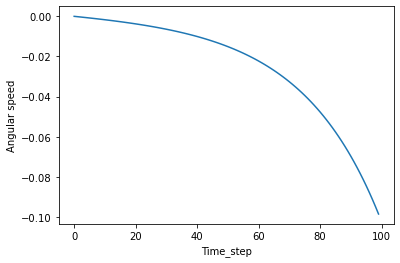

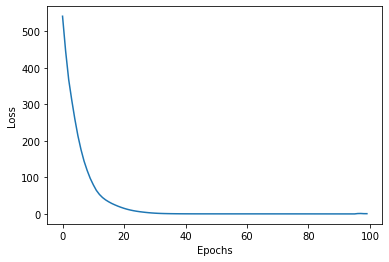

Final state vector for the best trajectory:  tensor([ 0.0435, -0.1558,  0.0069, -0.0983], grad_fn=<AddBackward0>)


In [693]:
# Now it's time to run the code!

T = 100  # number of time steps
dim_input = 4  # state space dimensions
dim_hidden = 24  # latent dimensions
dim_output = 2  # action space dimensions
d = Dynamics()  # define dynamics
c = Controller(dim_input, dim_hidden, dim_output)  # define controller
s = Simulation(c, d, T)  # define simulation
o = Optimize(s)  # define optimizer
o.train(100)  # solve the optimization problem

**Description of the problem:** \
The formulation of the rocket landing problem has been extended to include a flight path angle controller and aerodynamic drag. \
To test the controller in a range of situations, a batch of initial states were sampled from a normal distribution:
$$
x_{ij} \sim N(\mu_j, \sigma_j), i = 1, ... ,N \space j = 1, ... , M 
$$
In this case, we have N = 5 batches and M = 4 states. \
Each of the states are updated according to the forces external to the rocket and the forces exerted by the control input. The state variable formulation for this problem is as follows:
$$
x(t+1) = x(t) + \dot x(t)dt \\
\dot x(t+1) = \dot x(t) + \ddot x(t)dt \\
\nu(t+1) = x(t) + \dot \nu(t)dt \\
\dot \nu(t+1) = \dot \nu(t) + \ddot \nu(t)dt \\
$$
<center>

![Force diagram](FBD.png)

</center>
The update for the velocity and flight path angle are given as follows, assuming a constant mass system:

$$
d\dot x = (gcos(\nu) - a_{drag} - a_{thrust})dt \\
d\dot \nu = (gsin(\nu) - a_{cSurf})dt
$$
$ a_{cSurf} $ is the acceleration produced by the control input for changing the flight path angle. 